### Interpolating VBRc structures

In some situations, it may be useful to interpolate VBRc results at arbitrary points between calculated points. The sample file,`"VBRc_sample_LUT.mat"` was calculated for a very coarse grid of temperature (`T_K`), melt fraction (`phi`) and grain size(`dg_um`) at two frequencies to serve as a simple look-up table (LUT). You can provide these variable names to the `lut_dimensions` keyword argument when initializing the `VBRCstruct`:


In [1]:
from pyVBRc.vbrc_structure import VBRCstruct
from pyVBRc.sample_data import get_sample_filename

file = get_sample_filename("VBRc_sample_LUT.mat")
vbr = VBRCstruct(file, lut_dimensions=["T_K", "phi", "dg_um"])

pyVBRc : [INFO ] 2023-07-26 14:04:21,667:  /home/chavlin/src/vbrProjects/pyVBRc/pyVBRc/sample_data/VBRc_sample_LUT.mat loaded.


Now, you can build a grid interpolator for a single method-array and a single frequency index with the `interpolator` method. The method array to interpolate is specified as a tuple of output fieldnames: `("anelastic", "andrade_psp", "V")` corresponds to accessing `VBR.output.anelastic.andrade_psp.V`. 

This method also accepts the `log_vars` keyword argument that you can use to specify LUT fields that you want to interpolate in log-space:

In [2]:
interp = vbr.interpolator(
    ("anelastic", "andrade_psp", "V"), 0, log_vars=["phi", "dg_um"]
)

The interpolation object accepts a tuple of points to evaluate. To evaluate at a single point:

In [3]:
import numpy as np
# (T in K, log(phi), log(dg in micrometer))
target = (1333 + 273.0, np.log10(0.0012), np.log10(1131))
Vs_interp = interp(target)
print(Vs_interp)

4219.030239640764


To interpolate at more than one point, you can provide an array of points. The following cell constructs 1D temperature, melt fraction and grain size arrays to build a 3D array of points to interpolate to:

In [4]:
T = vbr.input.SV.T_K[:, 0, 0]
nT = len(T)
T_targets = np.linspace(T.min(), T.max(), nT * 2)
phival = vbr.input.SV.phi.min()
dgval = vbr.input.SV.dg_um.min()
phi_targets = np.full(T_targets.shape, np.log10(phival))
dg_targets = np.full(T_targets.shape, np.log10(dgval))
targets = np.column_stack((T_targets, phi_targets, dg_targets))
Vs_interp = interp(targets)
Vs_interp.shape

(20,)

Plotting up the interpolation on top of the original points:

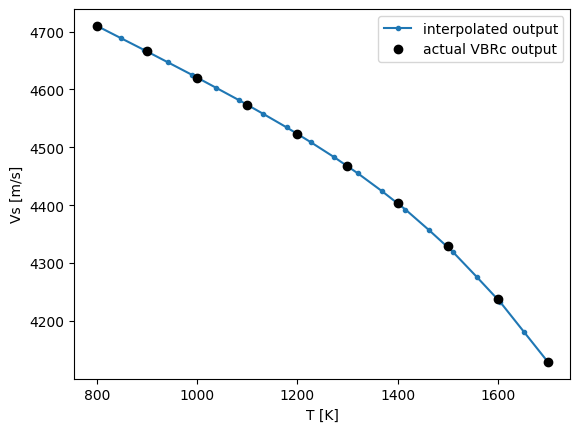

In [5]:
import matplotlib.pyplot as plt
actual_Vs = vbr.output.anelastic.andrade_psp.V[:, 0, 0, 0]
f = plt.figure()
plt.plot(T_targets, Vs_interp, label="interpolated output", marker=".")
plt.plot(T, actual_Vs, ".k", label="actual VBRc output", markersize=12)
plt.legend()
plt.xlabel("T [K]")
plt.ylabel("Vs [m/s]")
plt.show()
f.savefig('interpolate_example.png')

Note that `pyVBRc` does not make any attempt to verify that interpolating is accurate: you'll want to ensure that any discontinuous behavior (like near the solidus with using the `xfit_premelt` anelastic method) is sufficiently mapped out to capture that behavior. 